In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.signal import hilbert

# Criando uma série temporal estacionária

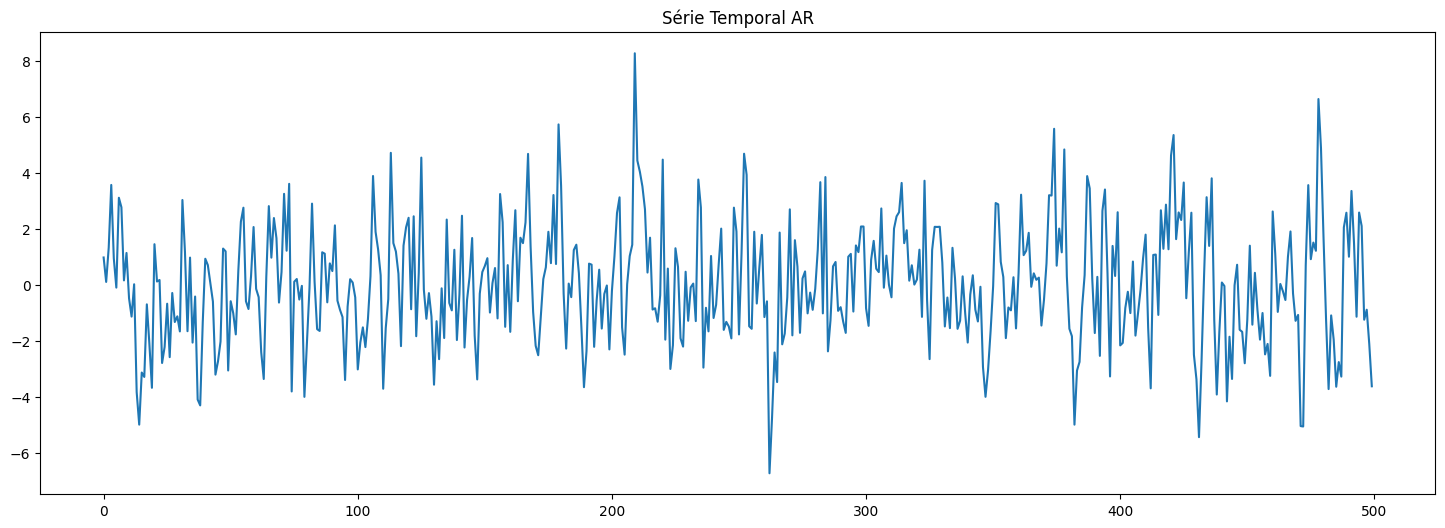

In [171]:
# Parâmetros do modelo AR
phi = np.array([0.5, -0.2])  # Coeficientes AR

# Gerar dados da série temporal AR
np.random.seed(42)
ar_data = sm.tsa.arma_generate_sample(ar=phi, ma=[1], nsample=500)

# Plotar a série temporal
plt.figure(figsize=(18,6))
plt.title("Série Temporal AR")
plt.plot(ar_data)
plt.show()

In [172]:
def adf_test(timeseries):
    print('H0: A série temporal é estacionária (caso valor-p < 0.05)')
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput[f"Critical Value ({key})"] = value
    print(dfoutput)

In [173]:
adf_test(ar_data) #série estacionária, p-value < 0.05

H0: A série temporal é estacionária (caso valor-p < 0.05)
Results of Dickey-Fuller Test:
Test Statistic                -1.468374e+01
p-value                        3.126709e-27
#Lags Used                     0.000000e+00
Number of Observations Used    4.990000e+02
Critical Value (1%)           -3.443523e+00
Critical Value (5%)           -2.867350e+00
Critical Value (10%)          -2.569864e+00
dtype: float64


In [174]:
def kpss_test(x, h0_type='c'):
  indices = ['Estatística do teste', 'valor-p', '# de Lags']
  kpss_test = kpss(x, regression=h0_type, nlags="legacy")
  results = pd.Series(kpss_test[0:3], index=indices)
  print('H0: A série temporal é estacionária (caso valor-p > 0.05)')
  for key, value in kpss_test[3].items():
    results[f'Critical Value ({key})'] = value
  
  return results

In [175]:
kpss_test(ar_data) #série estacionária se p-value > 0.05

H0: A série temporal é estacionária (caso valor-p > 0.05)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6316\699921468.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(x, regression=h0_type, nlags="legacy")


Estatística do teste      0.121247
valor-p                   0.100000
# de Lags                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

# Análise de Fourier
https://towardsdatascience.com/fourier-transform-for-time-series-292eb887b101

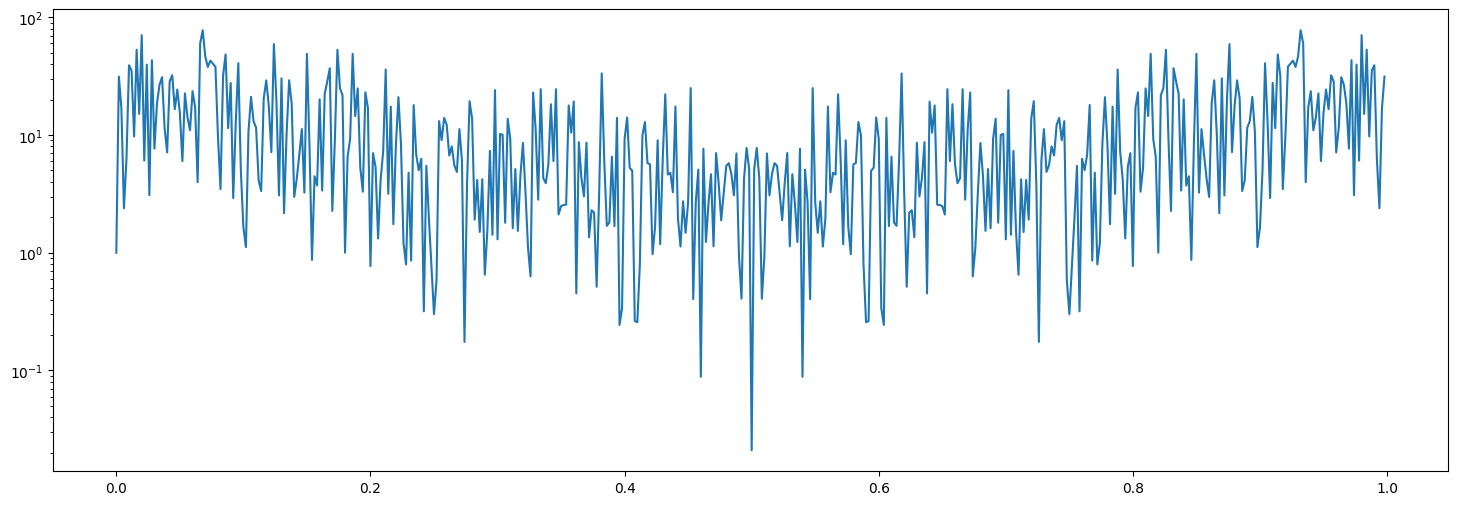

In [176]:
# apply fast fourier transform and take absolute values
f=abs(np.fft.fft(ar_data))

# get the list of frequencies
num=np.size(ar_data)
freq = [i / num for i in list(range(num))]

# get the list of spectrums
spectrum=f.real*f.real+f.imag*f.imag
nspectrum=spectrum/spectrum[0]

# plot nspectrum per frequency, with a semilog scale on nspectrum
plt.figure(figsize=(18,6))
plt.semilogy(freq,nspectrum)
plt.show()

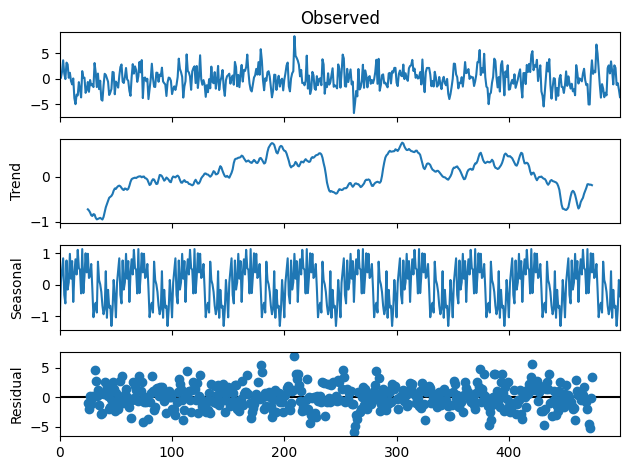

In [177]:
res = sm.tsa.seasonal_decompose(ar_data, model='additive', period=50)
res.plot()
plt.show()

## Plot da fase da sazonalidade

In [214]:
sinal_saz = res.seasonal
sinal_saz[:100], sinal_saz[400:] = np.zeros(100), np.zeros(100)

z = np.fft.fft(sinal_saz, axis=-1)
#z[0] = 0
#z[50:100] = np.zeros(50)

w = np.fft.ifft(z)

amp = 2 * np.abs(w)

fase = np.arctan2(np.imag(w), np.real(w))
#unwrapped_phase = np.unwrap(fase)
unwrapped_phase = np.unwrap(fase)

sinal_hilbert = hilbert(sinal_saz)
fase_hilbert = np.arctan2(np.imag(sinal_hilbert), np.real(sinal_hilbert))
unwrapped_phase_hilbert = np.unwrap(fase_hilbert)

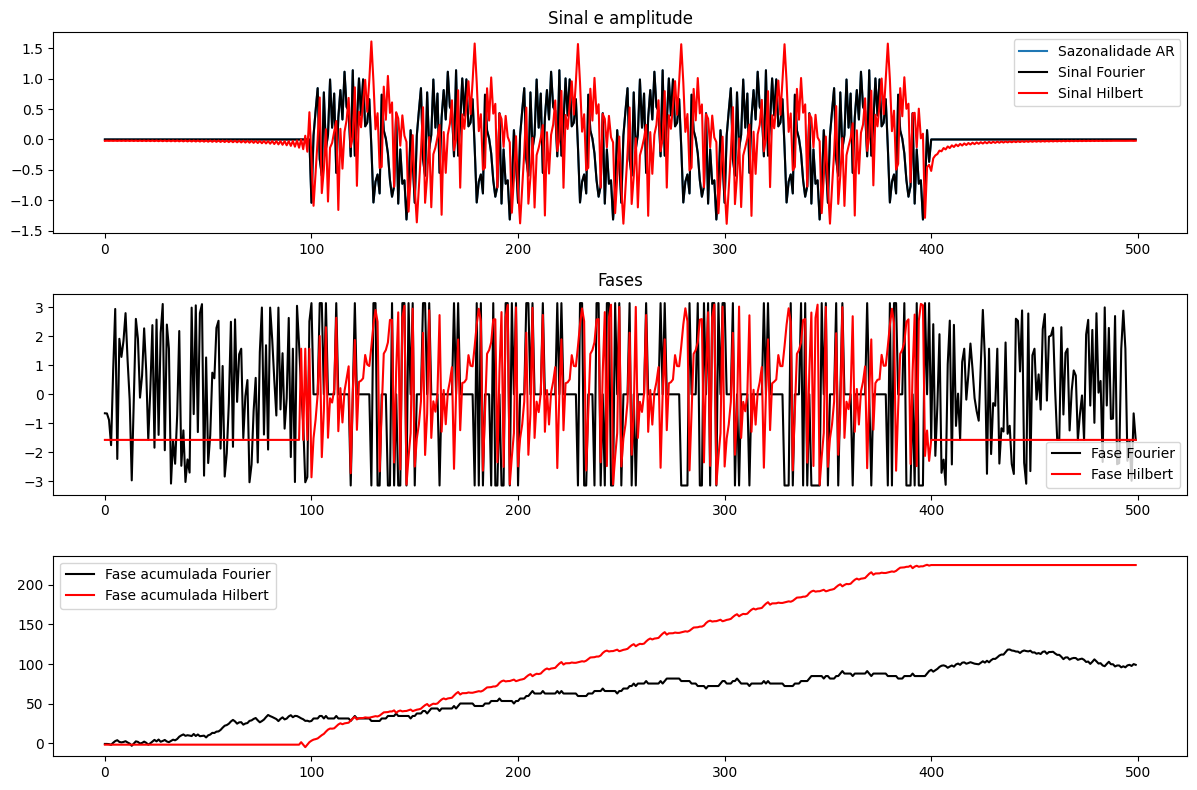

In [215]:
fig, ax = plt.subplots(3,1, figsize=(12,8))

ax[0].plot(sinal_saz, label='Sazonalidade AR')
ax[0].plot(w.real, label='Sinal Fourier', color='black')     #valores muito baixos
ax[0].plot(sinal_hilbert.imag, label='Sinal Hilbert', color='red')
#ax[0].plot(250*amp, label='Amplitude')
ax[0].legend(loc='upper right')
ax[0].set_title('Sinal e amplitude')

ax[1].plot(fase, color='black', label='Fase Fourier')
ax[1].plot(fase_hilbert, color='red', label='Fase Hilbert')
ax[1].set_title('Fases')
ax[1].legend()

ax[2].plot(unwrapped_phase, color='black', label='Fase acumulada Fourier')
ax[2].plot(unwrapped_phase_hilbert, color='red', label='Fase acumulada Hilbert')
ax[2].legend()

plt.tight_layout()

## Criando uma série temporal não estacionária

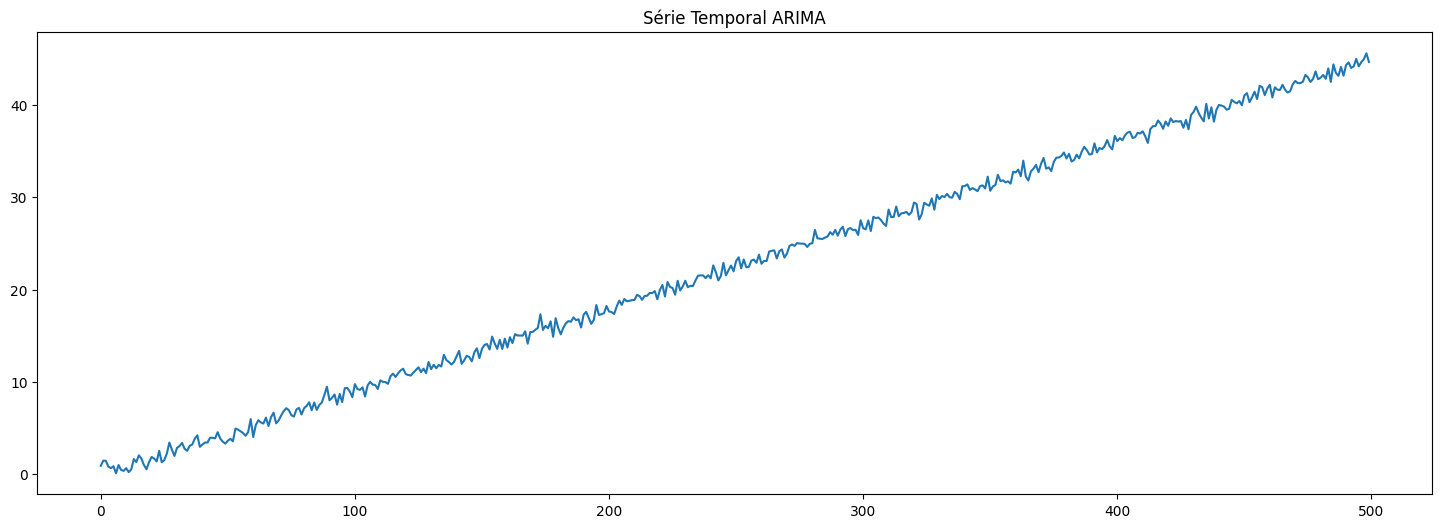

In [216]:
# Parâmetros do modelo ARIMA
p, d, q = 2, 1, 1  # Ordem do AR, Ordem da Diferenciação, Ordem do MA
np.random.seed(3)
arima_model = sm.tsa.ARIMA(endog=np.random.randn(500), order=(p, d, q))

# Ajustar o modelo aos dados
arima_result = arima_model.fit()

# Obter a série temporal simulada
arima_data = arima_result.fittedvalues

# Adicionar ruído
nivel_ruido = 0.5
arima_data = arima_data + nivel_ruido * np.random.randn(len(arima_data))

# Adicionar tendência linear
tend = 0.09 * np.arange(len(arima_data))
arima_data = arima_data + tend

# Plotar a série temporal
plt.figure(figsize=(18,6))
plt.plot(arima_data)
plt.title("Série Temporal ARIMA")
plt.show()

In [217]:
adf_test(arima_data)

H0: A série temporal é estacionária (caso valor-p < 0.05)
Results of Dickey-Fuller Test:
Test Statistic                   0.115795
p-value                          0.967123
#Lags Used                      15.000000
Number of Observations Used    484.000000
Critical Value (1%)             -3.443933
Critical Value (5%)             -2.867530
Critical Value (10%)            -2.569961
dtype: float64


In [218]:
kpss_test(arima_data)

H0: A série temporal é estacionária (caso valor-p > 0.05)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6316\699921468.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(x, regression=h0_type, nlags="legacy")


Estatística do teste      2.733038
valor-p                   0.010000
# de Lags                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

## Análise de Fourier

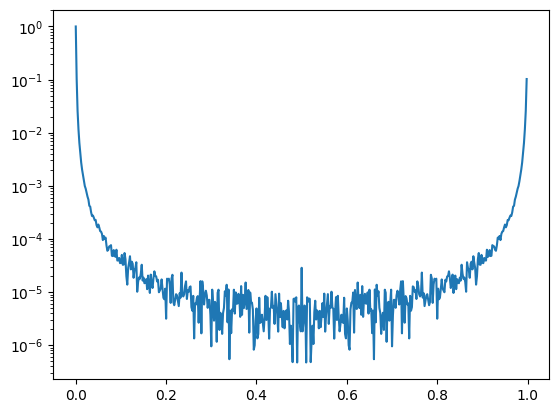

In [219]:
# apply fast fourier transform and take absolute values
f=abs(np.fft.fft(arima_data))

# get the list of frequencies
num=np.size(arima_data)
freq = [i / num for i in list(range(num))]

# get the list of spectrums
spectrum=f.real*f.real+f.imag*f.imag
nspectrum=spectrum/spectrum[0]

# plot nspectrum per frequency, with a semilog scale on nspectrum
plt.semilogy(freq,nspectrum)

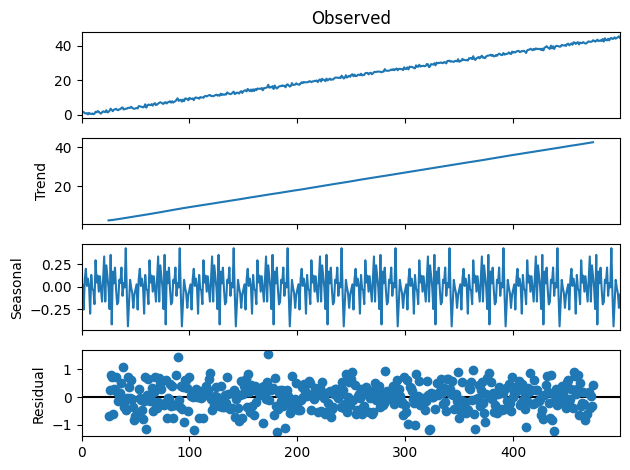

In [220]:
res = sm.tsa.seasonal_decompose(arima_data, model='additive', period=50)
res.plot()
plt.show()

## Plot da fase original

In [240]:
sinal = res.observed
#sinal[0:50], sinal[450:500] = np.zeros(50), np.zeros(50)

z = np.fft.fft(sinal, axis=-1)

w = np.fft.ifft(z)

amp = 2*np.abs(w)

fase = np.arctan2(np.imag(w), np.real(w))
unwrapped_phase = np.unwrap(fase)

sinal_hilbert = hilbert(sinal)
fase_hilbert = np.angle(sinal_hilbert)#np.arctan2(np.imag(sinal_hilbert), np.real(sinal_hilbert))
unwrapped_phase_hilbert = np.unwrap(fase_hilbert)

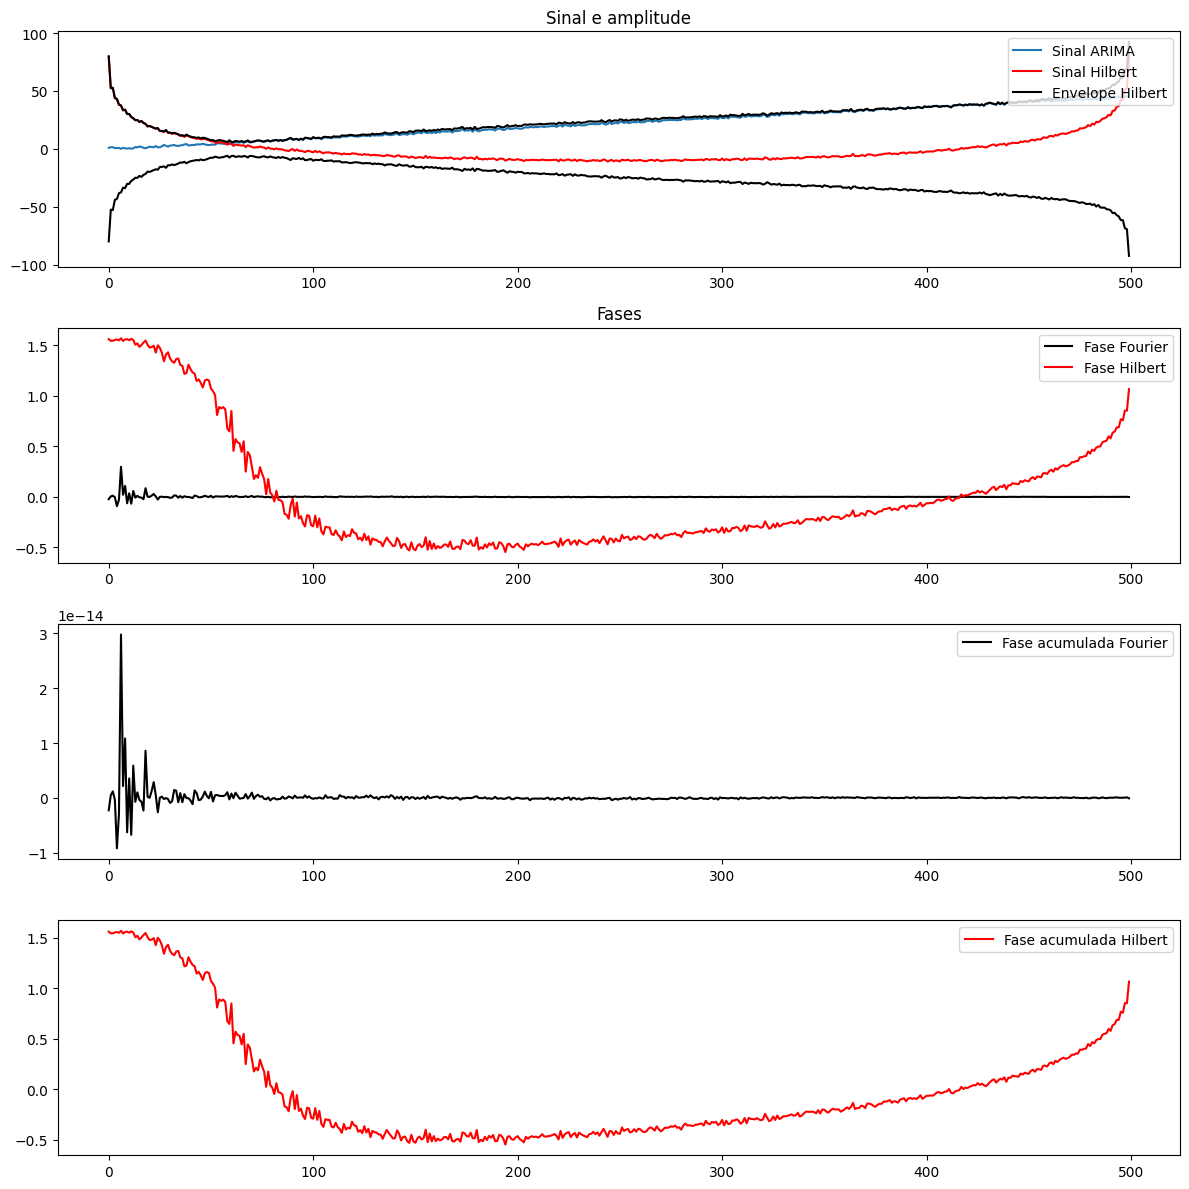

In [249]:
fig, ax = plt.subplots(4,1, figsize=(12,12))

ax[0].plot(sinal, label='Sinal ARIMA')
ax[0].plot(sinal_hilbert.imag, label='Sinal Hilbert', color='red')
#ax[0].plot(amp, label='Amplitude')
ax[0].plot(np.abs(sinal_hilbert), color='black', label='Envelope Hilbert')
ax[0].plot(-np.abs(sinal_hilbert), color='black')
ax[0].legend(loc='upper right')
ax[0].set_title('Sinal e amplitude')

ax[1].plot(fase*10e12, color='black', label='Fase Fourier')
ax[1].plot(fase_hilbert, color='red', label='Fase Hilbert')
ax[1].set_title('Fases')
ax[1].legend(loc='upper right')

ax[2].plot(unwrapped_phase, color='black', label='Fase acumulada Fourier')
ax[2].legend(loc='upper right')

ax[3].plot(unwrapped_phase_hilbert, color='red', label='Fase acumulada Hilbert')
ax[3].legend(loc='upper right')

plt.tight_layout()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [224]:
fase_hilbert[0:20]

array([1.55942197, 1.5427171 , 1.54337946, 1.55215364, 1.55564136,
       1.54816857, 1.56817186, 1.54118859, 1.55705253, 1.55893747,
       1.54906577, 1.56286002, 1.55115135, 1.50481136, 1.51819576,
       1.48301662, 1.50110186, 1.52659101, 1.54593364, 1.50394526])